In [13]:
import jax.numpy as jnp
import jinns
import jax.random as random
from jax import vmap
import jax

import equinox as eqx
import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

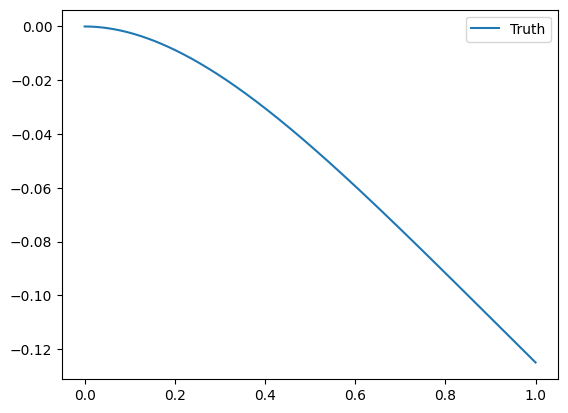

In [14]:
def u_true(x):
    return -(1 / 24) * x**4 + (1 / 6) * x**3 - (1 / 4) * x**2


v_u_true = vmap(u_true)

xs = jnp.linspace(0, 1, 1000)
plt.plot(xs, v_u_true(xs), label="Truth")
plt.legend()

## Solving Euler-Beam with Jinns

Create the neural network architecture for the PINN with `equinox`.

In [ ]:
dim = 1
eqx_list = (
    (eqx.nn.Linear, dim, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="statio_PDE"
)

In [16]:
n = 320
nb = 2
omega_batch_size = 32
omega_border_batch_size = None  # no mini-batches in dimension 1
dim = 1
min_pts = (0.0,)
max_pts = (1.0,)
method = "grid"

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_batch_size,
    dim=dim,
    min_pts=min_pts,
    max_pts=max_pts,
    method=method,
)

In [32]:
from jinns.loss import PDEStatio
from functools import partial


class EulerBeamLoss(PDEStatio):
    def equation(self, x, u, params):
        u_x = lambda x: partial(u, params=params)(x).squeeze()

        x4 = jax.grad(jax.grad(jax.grad(jax.grad(u_x))))(x)
        return x4 + 1

In [34]:
euler_beam_loss = EulerBeamLoss()
euler_beam_loss.equation(xs[0], u, init_nn_params)

Array(0.99908787, dtype=float32)